In [1]:
import scanpy as sc

import scipy.stats
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def cliffs_delta(x, y):
    nx = len(x)
    ny = len(y)
    n_greater = sum(i > j for i in x for j in y)
    n_less = sum(i < j for i in x for j in y)
    delta = (n_greater - n_less) / (nx * ny)
    return delta

In [ ]:
""" 
In this tutorial, we will analyze scRNA-seq data presented in Kinker et al. paper (https://doi.org/10.1038/s41588-020-00726-6).
This dataset encompasses 
We begin our tutorial from the count matrix generated from Cell Ranger (processed_)
"""

# Prepare input

In [ ]:
PATH_Kinker_adata       = '/node200data/18parkky/datasets/data/public/processed_data/CRC_MSI_intensity_analysis_clean_data/adata_k.preprocessed.NanoMnT.h5ad'
PATH_Kinker_metadata    = '/node200data/18parkky/datasets/data/public/processed_data/CRC_MSI_intensity_analysis_clean_data/Kinker_et_al.MSI_metadata.tsv'

# Kinker et al

In [4]:
adata = sc.read_h5ad(PATH_Kinker_adata)
adata.obs['CellLine_Name'] = [ CellLine.split('_')[0] for CellLine in adata.obs['CellLine'] ]
adata.obs['CellType'] = adata.obs['CellLine_Name']

In [6]:
MSI_metadata = pd.read_csv(PATH_Kinker_metadata, sep='\t')
MSI_metadata = MSI_metadata[(MSI_metadata['MSI status'].isin(['MSI', 'MSI-L', 'MSS']))]

dict_cellline_to_msi = { list(tup)[2] : list(tup)[3] for tup in MSI_metadata.itertuples() }

In [9]:
adata_MSI = adata[(adata.obs['CellLine_Name'].isin( MSI_metadata['Cell line'] )) & (adata.obs['NumSTRLoci']>=10)].copy()
print(adata_MSI.shape)
adata_MSI = adata_MSI.raw.to_adata()

adata_MSI.obs['MSI_GroundTruth'] = [ dict_cellline_to_msi[CellLine] for CellLine in adata_MSI.obs['CellLine_Name'] ]

sc.pp.highly_variable_genes(adata_MSI, n_top_genes=2000, batch_key="PoolID")

adata_MSI.raw = adata_MSI.copy()
adata_MSI = adata_MSI[:, adata_MSI.var.highly_variable]

sc.pp.scale(adata_MSI, max_value=10)
sc.tl.pca(adata_MSI, svd_solver="arpack")

sc.pp.neighbors(adata_MSI, n_neighbors=15, n_pcs=40)
sc.tl.tsne(adata_MSI)

(7019, 2000)


/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/preprocessing/_scale.py:316: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
2025-04-10 21:09:16.961902: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-10 21:09:17.393555: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-10 21:09:17.397689: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-10 21:09:17.408668: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-10 

In [24]:
adata_MSI.write('/node200data/18parkky/datasets/data/public/processed_data/CRC_MSI_intensity_analysis_clean_data/NanoMnT_scMSI/test/adata_test.kinker_et_al.h5ad')

In [18]:
NormalCellTypes = list(adata_MSI.obs[(adata_MSI.obs['MSI_GroundTruth']=='MSS')]['CellType'])

In [20]:
df = adata_MSI.obs[(adata_MSI.obs['NumSTRLoci']>=10)].copy()

NormalMSIscores = df[df['CellType'].isin(NormalCellTypes)]['MSI_score']

TestResults = list()
for CellType, edf in df[~(df['CellType'].isin(NormalCellTypes))].groupby('CellType', observed=True):
    MSI_scores = edf['MSI_score']
    
    sample_n = min([len(NormalMSIscores), len(MSI_scores)])
    
    stat, pval = scipy.stats.ks_2samp(MSI_scores.sample(sample_n, random_state=42), NormalMSIscores.sample(sample_n, random_state=42))
    delta = cliffs_delta(MSI_scores, NormalMSIscores)

    TestResults.append( [CellType, pval, delta] )
TestResults = pd.DataFrame(TestResults, columns=['CT', 'pval', 'delta'])
TestResults['logPval'] = [ -np.log(pval+10**-10) for pval in TestResults['pval'] ]

pval_threshold  = 0.01 
delta_threshold = 0.4

MSI_celltypes = list()

TestResults_significant = TestResults[(TestResults['pval']<=pval_threshold) & 
                                      ((TestResults['delta']>=delta_threshold) | (TestResults['delta']<=-delta_threshold))]

for tup in TestResults_significant.itertuples():
    MSI_celltypes.append( tup.CT )

TestResults_significant.reset_index(inplace=True, drop=True)
TestResults_significant

,CT,pval,delta,logPval
0,2313287,3.502446e-61,0.999475,23.025851
1,CCK81,1.381387e-75,0.999626,23.025851
2,CL34,5.191065e-221,0.999152,23.025851
3,HEC6,5.268615e-96,0.999460,23.025851
4,HEC59,1.120417e-230,0.999530,23.025851
5,HEC108,1.298274e-102,0.999582,23.025851
6,HEC151,1.713146e-149,0.999602,23.025851
7,IM95,2.006254e-110,0.999454,23.025851
8,LS180,3.053881e-216,0.999454,23.025851
9,MFE319,1.901126e-111,0.999170,23.025851


## Load AnnData - Cell types must be prepared

In [2]:
adata = sc.read_h5ad('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/2_cell_type_labeled_h5ad/Joanito.MSI.preprocessed.NanoMnT.ManualAnnot.MSI_score_labeled.lvl3.h5ad')

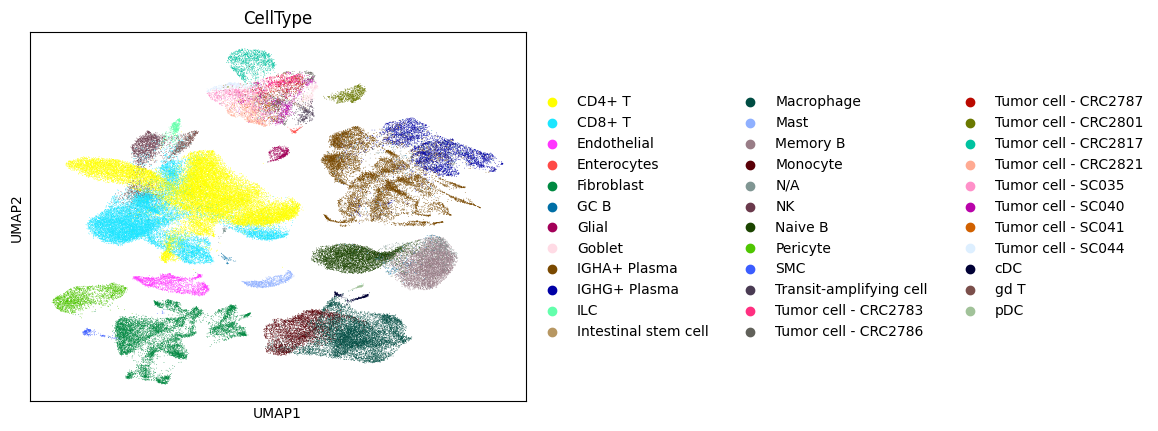

In [38]:
adata.obs['CellType'] = adata.obs['Manual_CellType_lvl_3']
sc.pl.umap(adata, color=['CellType'])

In [39]:
# Separate tumor cells by Patient IDs
temp = list()
for tup in adata.obs.itertuples():
    if tup.CellType == 'Tumor cell':
        temp.append( f'Tumor cell - {tup.PatientID}' )
    else:
        temp.append( tup.CellType )
        
adata.obs['CellType'] = temp

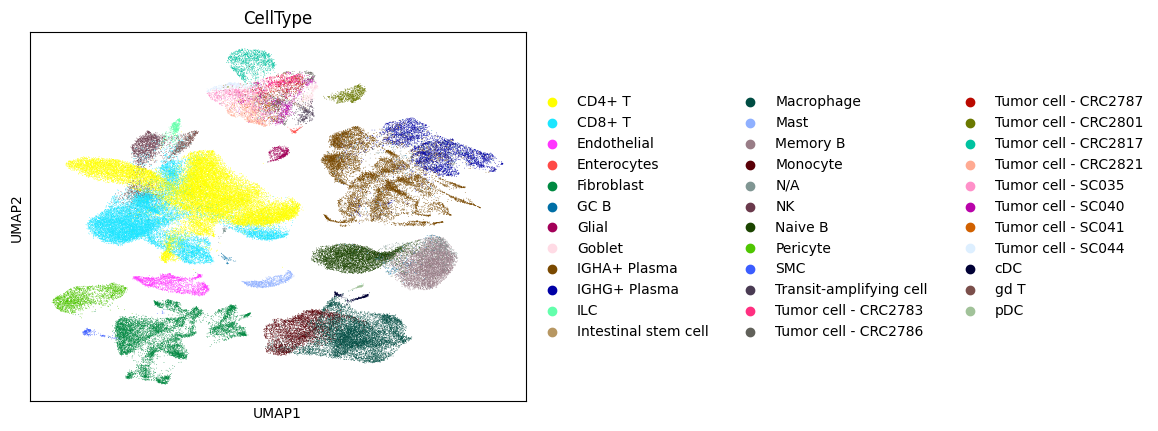

In [40]:
sc.pl.umap(adata, color=['CellType'])

## Find MSI cell types

In [41]:
NormalCellTypes =  ['Endothelial', 'CD4+ T', 'SMC', 'GC B', 
                    'gd T', 'CD8+ T', 'ILC', 'Naive B', 'Glial',
                    'Pericyte', 'NK', 'pDC', 'Monocyte', 'IGHA+ Plasma', 
                    'Fibroblast', 'Mast', 'IGHG+ Plasma', 'Memory B',
                    'Macrophage', 'cDC', ] # All cell types except Epithelial cells (Tumor cells + Normal epithelial cells)

In [42]:
df = adata.obs[(adata.obs['NumSTRLoci']>=20)].copy()

NormalMSIscores = df[df['CellType'].isin(NormalCellTypes)]['MSI_score']

In [43]:
TestResults = list()
for CellType, edf in df[~(df['CellType'].isin(NormalCellTypes))].groupby('CellType', observed=True):
    MSI_scores = edf['MSI_score']
    
    sample_n = min([len(NormalMSIscores), len(MSI_scores)])
    
    stat, pval = scipy.stats.ks_2samp(MSI_scores.sample(sample_n, random_state=42), NormalMSIscores.sample(sample_n, random_state=42))
    delta = cliffs_delta(MSI_scores, NormalMSIscores)

    TestResults.append( [CellType, pval, delta] )
TestResults = pd.DataFrame(TestResults, columns=['CT', 'pval', 'delta'])
TestResults['logPval'] = [ -np.log(pval+10**-10) for pval in TestResults['pval'] ]

In [64]:
pval_threshold  = 0.01 
delta_threshold = 0.4

MSI_celltypes = list()

TestResults_significant = TestResults[(TestResults['pval']<=pval_threshold) & 
                                      ((TestResults['delta']>=delta_threshold) | (TestResults['delta']<=-delta_threshold))]

for tup in TestResults_significant.itertuples():
    MSI_celltypes.append( tup.CT )

TestResults_significant

,CT,pval,delta,logPval
5,Tumor cell - CRC2783,0.000000e+00,0.994941,23.025851
9,Tumor cell - CRC2817,0.000000e+00,0.845638,23.025851
11,Tumor cell - SC035,0.000000e+00,0.996877,23.025851
14,Tumor cell - SC044,7.860408e-208,0.999104,23.025851


## Visualize results

### MSI cell types

In [65]:
adata.obs['isMSI'] = [ bool(CT in MSI_celltypes) for CT in adata.obs['CellType'] ]

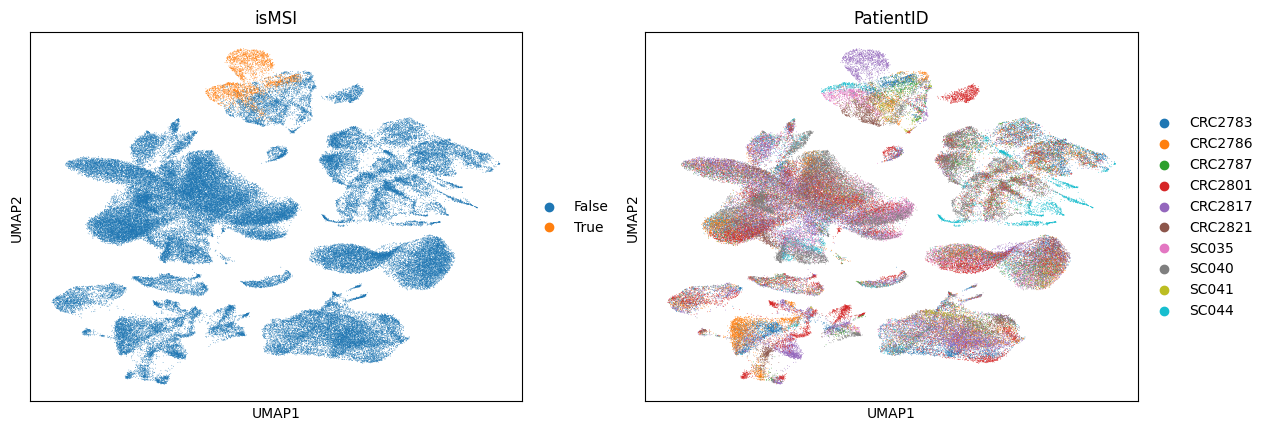

In [67]:
sc.pl.umap(adata, color=['isMSI', 'PatientID'])

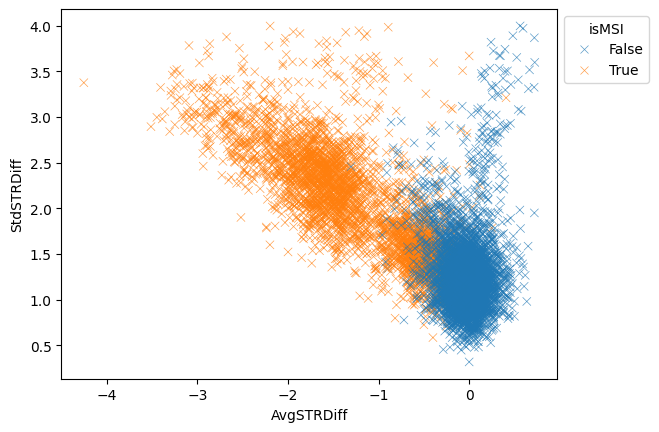

In [99]:
df = adata.obs[(adata.obs['Author_CellType_lvl_1']=='Epithelial') & (adata.obs['NumSTRLoci']>=20) & (adata.obs['StdSTRDiff']<=4)].copy()
df.CellType = df.CellType.cat.remove_unused_categories()

ax = sns.scatterplot(data=df, x='AvgSTRDiff', y='StdSTRDiff', marker='x', alpha=0.75, hue='isMSI', legend=True, )
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

### MSI score (z-score)

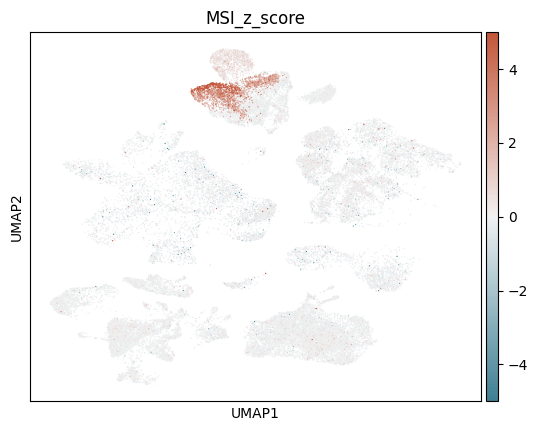

In [69]:
u, s = np.mean( adata.obs[(adata.obs['NumSTRLoci']>=20)]['MSI_score'] ), np.std( adata.obs[(adata.obs['NumSTRLoci']>=20)]['MSI_score'] )
adata.obs['MSI_z_score'] = [ (MSIscore-u)/s for MSIscore in adata.obs['MSI_score'] ]

z_score_threshold = 5

sc.pl.umap(adata[(adata.obs['NumSTRLoci']>=20)], 
           color='MSI_z_score', 
           vmin=-z_score_threshold, vmax=z_score_threshold,
           cmap=sns.diverging_palette(220, 20, as_cmap=True,))